In [1]:
import torch
import captum
from train_without_embedding_bag import TextClassificationModel
from torchtext.datasets import AG_NEWS
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from captum.attr import LimeBase, KernelShap
from captum._utils.models.linear_model import SkLearnLasso
import torch.nn.functional as F
from IPython.core.display import HTML, display
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer, GradientShap
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization, IntegratedGradients
# import shap
from scipy.stats.stats import pearsonr
import itertools


NUM_EXPLANATIONS = 3
EXPLANATIONS = dict()
EXPLANATION_NAMES = dict()
pointer = 0

In [2]:
def num_to_text(text_nums, vocab) :
    return [vocab.vocab.itos_[i] for i in text_nums]

In [3]:
    PATH = "./text_classification_no_offset.model"
    tokenizer = get_tokenizer('basic_english')
    train_iter = AG_NEWS(split='train')

    def yield_tokens(data_iter):
        for _, text in data_iter:
            yield tokenizer(text)

    vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
    vocab.set_default_index(vocab["<unk>"])

    text_pipeline = lambda x: vocab(x)
    label_pipeline = lambda x: int(x) - 1

    #

train.csv: 29.5MB [00:00, 37.4MB/s]                                                                                               


In [4]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def append_pads(text, max_len):
        text.extend(['<pad>']*(max_len-len(text)))

    def collate_batch(batch):
        batch = [(i[0], tokenizer(i[1]) ) for i in batch]
        max_len = max([len(i[1]) for i in batch])
        label_list, text_list = [], []
        for (_label, _text) in batch:
            label_list.append(label_pipeline(_label))
            append_pads(_text, max_len)
            processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
            text_list.append(processed_text)
        label_list = torch.tensor(label_list, dtype=torch.int64)
        text_list = torch.stack(text_list)
        return label_list.to(device), text_list.to(device)


    train_iter = AG_NEWS(split='train')
    num_class = len(set([label for (label, text) in train_iter]))
    vocab_size = len(vocab)
    emsize = 64
    #model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
    model = torch.load(PATH, map_location=torch.device('cpu'))
    import time

In [5]:
    def train(dataloader):
        model.train()
        total_acc, total_count = 0, 0
        log_interval = 500
        start_time = time.time()

        for idx, (label, text) in enumerate(dataloader):
            optimizer.zero_grad()
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            if idx % log_interval == 0 and idx > 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches '
                      '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                                  total_acc / total_count))
                total_acc, total_count = 0, 0
                start_time = time.time()

In [6]:
    def evaluate(dataloader):
        model.eval()
        total_acc, total_count = 0, 0

        with torch.no_grad():
            for idx, (label, text) in enumerate(dataloader):
                #print("One test label : ", text.shape, offsets.shape)
                predicted_label = model(text)
                text_converted = num_to_text(text, vocab)
                loss = criterion(predicted_label, label)
                total_acc += (predicted_label.argmax(1) == label).sum().item()
                total_count += label.size(0)
        return total_acc / total_count

    # Hyperparameters
    EPOCHS = 1  # epoch
    LR = 5  # learning rate
    BATCH_SIZE = 1  # batch size for training

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    total_accu = None
    train_iter, test_iter = AG_NEWS()

    train_dataset = to_map_style_dataset(train_iter)

    test_dataset = to_map_style_dataset(test_iter)
    num_train = int(len(train_dataset) * 0.95)
    split_train_, split_valid_ = \
        random_split(train_dataset, [num_train, len(train_dataset) - num_train])


    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                 shuffle=True, collate_fn=collate_batch)

    
    



test.csv: 1.86MB [00:00, 17.6MB/s]                                                                                                


In [7]:
    # Lime Code
    # remove the batch dimension for the embedding-bag model
    def forward_func(text):
        return model(text)

    # encode text indices into latent representations & calculate cosine similarity
    def exp_embedding_cosine_distance(original_inp, perturbed_inp, _, **kwargs):
        original_emb = torch.mean(model.embedding(original_inp), dim = -2)
        perturbed_emb = torch.mean(model.embedding(perturbed_inp), dim = -2)
        #print("-->>", original_emb.shape, perturbed_emb.shape, model.embedding(original_inp).shape)
        distance = 1 - F.cosine_similarity(original_emb, perturbed_emb, dim=1)
        return torch.exp(-1 * (distance ** 2) / 2)

    # binary vector where each word is selected independently and uniformly at random
    def bernoulli_perturb(text, **kwargs):
        probs = torch.ones_like(text) * 0.5
        return torch.bernoulli(probs).long()

    # remove abscent token based on the intepretable representation sample
    def interp_to_input(interp_sample, original_input, **kwargs):
        return original_input[interp_sample.bool()].view(original_input.size(0), -1)


    
    lasso_lime_base = LimeBase(
        forward_func,
        interpretable_model=SkLearnLasso(alpha=0.08),
        similarity_func=exp_embedding_cosine_distance,
        perturb_func=bernoulli_perturb,
        perturb_interpretable_space=True,
        from_interp_rep_transform=interp_to_input,
        to_interp_rep_transform=None
    )
    
    test_label = 2  # {1: World, 2: Sports, 3: Business, 4: Sci/Tec}
    test_line = ('US Men Have Right Touch in Relay Duel Against Australia THENS, Aug. 17 '
                 '- So Michael Phelps is not going to match the seven gold medals won by Mark Spitz. '
                 'And it is too early to tell if he will match Aleksandr Dityatin, '
                 'the Soviet gymnast who won eight total medals in 1980.')

    test_labels, test_text = collate_batch([(test_label, test_line)])
    print(test_text, model(test_text))

    probs = F.softmax(model(test_text), dim=1).squeeze(0)
    print('Prediction probability:', round(probs[test_labels[0]].item(), 4), probs)

    attrs_laso = lasso_lime_base.attribute(
        test_text,  # add batch dimension for Captum
        target=test_labels,
        n_samples=32000,
        show_progress=True
    ).squeeze(0)
    #attrs = F.normalize(attrs, p=2.0, dim=0, eps=1e-12, out=None)

    #print(attrs)
    def show_text_attr(attrs):
        rgb = lambda x: '255,0,0' if x < 0 else '0,255,0'
        alpha = lambda x: abs(x) ** 0.5
        token_marks = [
            f'<mark style="background-color:rgba({rgb(attr)},{alpha(attr)})">{token}</mark>'
            for token, attr in zip(tokenizer(test_line), attrs.tolist())
        ]
    
        display(HTML('<p>' + ' '.join(token_marks) + '</p>'))
    
    

show_text_attr(attrs_laso)

tensor([[   36,   433,    39,   479,  3535,     7,  3760,  8161,    63,   270,
         20506,     3,  1146,     1,   782,    15,   303,   578,  2205,    21,
            62,   664,     4,   620,     2,   472,   276,  2823,   192,    24,
           600, 12368,     1,     8,    25,    21,   634,   258,     4,  2596,
           156,    49,    33,   620, 59251, 44655,     3,     2,  6920,  7455,
            75,   192,   630,  1321,  2823,     7,  8714,     1]]) tensor([[-0.5682,  3.3851, -0.5114, -1.9342]], grad_fn=<AddmmBackward>)
Prediction probability: 0.9575 tensor([0.0184, 0.9575, 0.0194, 0.0047], grad_fn=<SqueezeBackward1>)


Lime Base attribution: 100%|██████████████████████████████████████████████████████████████| 32000/32000 [00:08<00:00, 3985.39it/s]


In [8]:
EXPLANATIONS[pointer] = attrs_laso.detach().numpy()
EXPLANATION_NAMES['LI'] = pointer
pointer += 1


In [9]:
test_label = 2  # {1: World, 2: Sports, 3: Business, 4: Sci/Tec}
test_line = ('US Men Have Right Touch in Relay Duel Against Australia THENS, Aug. 17 '
                 '- So Michael Phelps is not going to match the seven gold medals won by Mark Spitz. '
                 'And it is too early to tell if he will match Aleksandr Dityatin, '
                 'the Soviet gymnast who won eight total medals in 1980.')

test_labels, test_text = collate_batch([(test_label, test_line)])


interpretable_embedding = configure_interpretable_embedding_layer(model, 'embedding')

/Users/lishloaner/miniconda3/lib/python3.9/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [10]:
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                        token_type_ids=None, ref_token_type_ids=None, \
                                        position_ids=None, ref_position_ids=None):
        input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
        ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
        return input_embeddings, ref_input_embeddings

In [11]:



layer_grad_shap = KernelShap(model) 
baselines = torch.zeros(test_text.shape[0]).to(torch.int64)
input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(test_text, baselines)

# attribution = layer_grad_shap.attribute(input_embeddings, ref_input_embeddings,
#                                             target=test_labels)   
attribution_shap = torch.sum(layer_grad_shap.attribute(input_embeddings, ref_input_embeddings,
                                            target=test_labels)*input_embeddings, dim = -1)

In [12]:
# attribution = torch.mean(attribution, dim = -1)*10000
# attribution_summed = torch.sum(attribution, dim=-1)


In [13]:
attribution_shap = attribution_shap *100

In [14]:
EXPLANATIONS[pointer] = attribution_shap[0].detach().numpy()
EXPLANATION_NAMES['SH'] = pointer
pointer += 1


In [15]:
# attribution = F.normalize(attribution, p=2.0, dim=0, eps=1e-2, out=None)

In [16]:
# attribution2 = F.normalize(attribution, p=2.0, dim=0)

def show_text_attr(attrs):
        rgb = lambda x: '255,0,0' if x < 0 else '0,255,0'
        alpha = lambda x: abs(x) ** 0.5
        token_marks = [
            f'<mark style="background-color:rgba({rgb(attr)},{alpha(attr)})">{token}</mark>'
            for token, attr in zip(tokenizer(test_line), attrs.tolist())
        ]    
        display(HTML('<p>' + ' '.join(token_marks) + '</p>'))
    
show_text_attr(attribution_shap.squeeze(0))

In [17]:
from captum.attr import IntegratedGradients

In [18]:
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                        token_type_ids=None, ref_token_type_ids=None, \
                                        position_ids=None, ref_position_ids=None):
        input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
        ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
        return input_embeddings, ref_input_embeddings

In [19]:
from captum.attr import IntegratedGradients, TokenReferenceBase, visualization

token_reference = TokenReferenceBase(reference_token_idx=0)
vis_data_records_ig = []



def interpret_sentence(model, test_text, test_labels,  pred, pred_ind, min_len=7, interpretable_embedding = None, label=0):
        model.zero_grad()
        # input_indices dim: [sequence_length]
        seq_length = test_text.shape[0]
        # predic

        # generate reference indices for each sample
        
        reference_indices = token_reference.generate_reference(seq_length, device=device)
        input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(test_text, reference_indices, interpretable_embedding)
        # compute attributions and approximation delta using layer integrated gradients
        ig = IntegratedGradients(model)
        attributions_ig = ig.attribute(input_embeddings, ref_input_embeddings, #additional_forward_args=(test_offsets,),\
                                               n_steps=500, target=test_labels)
        return attributions_ig #*input_embeddings

model = torch.load(PATH)
test_label = 2  # {1: World, 2: Sports, 3: Business, 4: Sci/Tec}
test_line = ('US Men Have Right Touch in Relay Duel Against Australia THENS, Aug. 17 '
                 '- So Michael Phelps is not going to match the seven gold medals won by Mark Spitz. '
                 'And it is too early to tell if he will match Aleksandr Dityatin, '
                 'the Soviet gymnast who won eight total medals in 1980.')
test_labels, test_text = collate_batch([(test_label, test_line)])
pred = F.softmax(model(test_text), dim=1)
pred_ind = torch.round(pred)
interpretable_embedding = configure_interpretable_embedding_layer(model, 'embedding')
attrs_ig = interpret_sentence(model, test_text, test_labels,  pred,pred_ind,  label=2, interpretable_embedding=interpretable_embedding)


/Users/lishloaner/miniconda3/lib/python3.9/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [20]:
attrs_ig = torch.sum(attrs_ig, dim = -1)

In [21]:
EXPLANATIONS[pointer] = attrs_ig[0].detach().numpy()
EXPLANATION_NAMES['IG'] = pointer
pointer += 1


In [22]:
show_text_attr(attrs_ig[0])

In [23]:
# attrs_ig_corr = attrs_ig[0]
# attribution_shap_corr = attribution_shap[0]
# attribution_lime_corr = attrs_laso

In [24]:
# TODO : Smooth Grad
# TODO : Adversarial Methods
# TODO : Some more for 

In [25]:
import numpy as np
corr_matrix = np.zeros([pointer, pointer])
for col_a, col_b in itertools.combinations_with_replacement(range(pointer), 2):
    corr_matrix[col_a][col_b], _ = pearsonr(EXPLANATIONS[col_a], EXPLANATIONS[col_b])
    corr_matrix[col_b][col_a] = corr_matrix[col_a][col_b]

In [26]:
def plot_confusion_matrix(index = None, column = None, data = None, plot_path = None):
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    # array = [[33, 2, 0, 0, 0, 0, 0, 0, 0, 1, 3],
    #          [3, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    #          [0, 4, 41, 0, 0, 0, 0, 0, 0, 0, 1],
    #          [0, 1, 0, 30, 0, 6, 0, 0, 0, 0, 1],
    #          [0, 0, 0, 0, 38, 10, 0, 0, 0, 0, 0],
    #          [0, 0, 0, 3, 1, 39, 0, 0, 0, 0, 4],
    #          [0, 2, 2, 0, 4, 1, 31, 0, 0, 0, 2],
    #          [0, 1, 0, 0, 0, 0, 0, 36, 0, 2, 0],
    #          [0, 0, 0, 0, 0, 0, 1, 5, 37, 5, 1],
    #          [3, 0, 0, 0, 0, 0, 0, 0, 0, 39, 0],
    #          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38]]
    df_cm = pd.DataFrame(data, index=index,
                         columns=column)
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm) # annot=True)
    plt.savefig(plot_path)

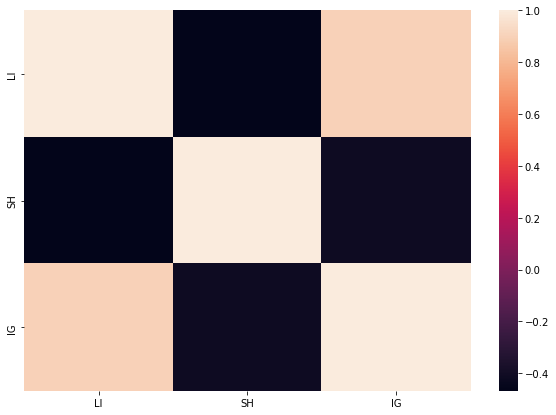

In [27]:
plot_confusion_matrix(index = EXPLANATION_NAMES.keys(), column = EXPLANATION_NAMES.keys(), data = corr_matrix, plot_path = "three.png")



In [70]:
corr_matrix

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])